In [1]:
using IndexedGraphs, SparseArrays, MatrixProductBP, Random, Plots, ColorSchemes, Statistics, LaTeXStrings,
    Unzip
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear)
using JLD2, UnPack
using ThreadedIterables

In [2]:
include("wolff.jl")
include("onsager.jl");

In [3]:
function rfim2d_montecarlo(N, β, J, hstd, ninstances;
        ntherm=10^4, nsamples=10^6, hbias=0)
    βJ = β * J * lattice((N, N), (false, true))
    
    # delete bonds between spins (N,2N), (2N,3N) and so on, because they correspond to interaction xᵢ^ᵀ,xⱼ^ᵀ in
    #  the dynamical model, which are not supported
    bonds_to_delete = [(N*(N-1)+i,N*(N-1)+mod(i,N)+1) for i in 1:N]
    for b in bonds_to_delete
       βJ[b...] = βJ[reverse(b)...] = 0 
    end
    dropzeros!(βJ)
    
    return @threaded map(1:ninstances) do _
        h = hstd * randn(N*N) .+ hbias
        stats = Stats(N*N)
        wolff(βJ, β*h, nsamples, stats; ntherm)
        stats
    end
end

function observables_mc(N, s)
    li = LinearIndices(zeros(N, N))
    mabs = magnetization.(s)
    m = magnetizations.(s)
    c = map(correlations.(s)) do c_mc_full
        c_mc_ij = map(e for e in edges(IndexedBiDiGraph(chain(N, false))) if src(e)<dst(e)) do e
            i,j = e
            map(1:N-1) do t
                c_mc_full[li[i,t], li[j,t]]
            end
        end
        c_mc_tt1 = map(1:N) do i
            # discard the last "time" index since it corresponds to a dishomogeneous part of the lattice
           map(1:N-2) do t
               c_mc_full[li[i,t], li[i,t+1]] 
            end
        end
        vcat(reduce(vcat, c_mc_ij), reduce(vcat, c_mc_tt1))
    end
    mabs, c, m
end

observables_mc (generic function with 1 method)

In [4]:
N = 5
J = 1.0
hstd = 0.1
hbias = 0
ninstances = 2
ntherm = 10^4
nsamples = 5*10^5;

In [38]:
betas = 0:0.2:1.2
@time begin
    stats = map(betas) do β
        println("Temperature β=$β")
        rfim2d_montecarlo(N, β, J, hstd, ninstances; ntherm, nsamples, hbias)
    end
end;

Temperature β=0.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00

Temperature β=0.2


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Temperature β=0.4


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Temperature β=0.6


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Temperature β=0.8


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Temperature β=1.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01                                                                                    


Temperature β=1.2


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


 10.348003 seconds (22.03 M allocations: 4.585 GiB, 13.49% gc time, 14.06% compilation time)


In [39]:
mabs_mc, c_mc, m_mc = observables_mc.(N, stats) |> unzip;

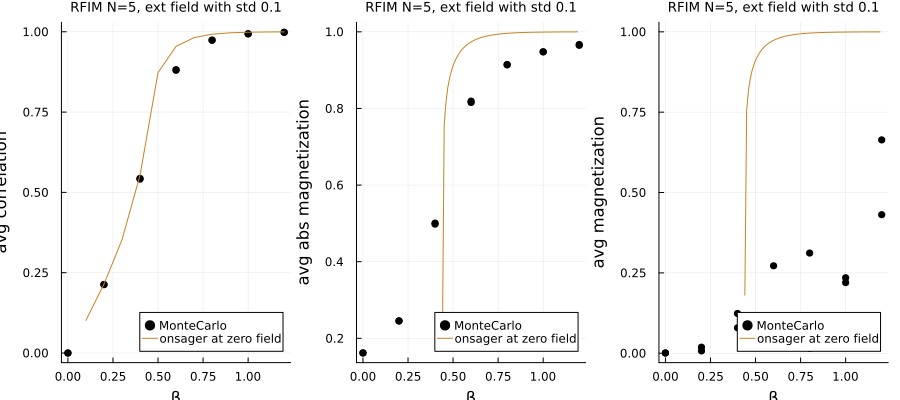

In [40]:
pl1 = plot(xlabel="β", ylabel="avg correlation", title="RFIM N=$N, ext field with std $hstd")
for i in eachindex(betas)
    scatter!(pl1, fill(betas[i], ninstances), mean.(c_mc[i]), c=:black, 
        label=(i == 1 ? "MonteCarlo" : ""))
end
plot!(pl1, β -> -onsager_energy(J, β)/2,  betas[1]:0.1:betas[end], label="onsager at zero field")

pl2 = plot(xlabel="β", ylabel="avg abs magnetization", title="RFIM N=$N, ext field with std $hstd")
for i in eachindex(betas)
    scatter!(pl2, fill(betas[i], ninstances), [mean(abs, mm) for mm in mabs_mc[i]], c=:black, 
        label=(i == 1 ? "MonteCarlo" : ""))
end
βc = log(1+sqrt(2))/(2J)
plot!(pl2, β->(1-sinh(2*β*J)^(-4))^(1/8), βc+1e-7:0.01:betas[end], label="onsager at zero field")

pl3 = plot(xlabel="β", ylabel="avg magnetization", title="RFIM N=$N, ext field with std $hstd")
for i in eachindex(betas)
    scatter!(pl3, fill(betas[i], ninstances), abs.(mean.(m_mc[i])), c=:black, 
        label=(i == 1 ? "MonteCarlo" : ""))
end
plot!(pl3, β->(1-sinh(2*β*J)^(-4))^(1/8), βc+1e-7:0.01:betas[end], label="onsager at zero field")
plot(pl1, pl2, pl3, size=(900,400), legend=:bottomright, layout=(1,3), titlefontsize=9)

## MPBP infinite
MPBP on infinite closed path graph

In [5]:
struct Ising2DInfinite{T<:Real}  <: BPFactor 
    βJv :: T
    βJh :: T
end

spin(x, i = 0) = 3-2x

function (f::Ising2DInfinite)(xᵢᵗ⁺¹::Integer,xₙᵢᵗ::AbstractVector{<:Integer}, xᵢᵗ::Integer)
    h = spin(xᵢᵗ)*(f.βJv*spin(xᵢᵗ⁺¹) + 0.5*f.βJh*sum(spin, xₙᵢᵗ) )
    exp(h)
end


function rfim2d_bp(N, β, J, hstd, ninstances;
        svd_trunc = TruncBondThresh(8, 1e-8), maxiter = 100, hbias=0)
    wᵢ = [Ising2DInfinite(β*J, β*J) for _ in 1:N]
    m, c = @threaded map(1:ninstances) do _
        hh = hstd * randn(N) .+ hbias
        ϕᵢ = [[exp(β*ht), exp(-β*ht)] for ht in hh]
        bp_inf = mpbp_infinite_graph(2, wᵢ, 2, ϕᵢ)
        cb = CB_BP(bp_inf; f=spin, showprogress=false)
        iters, cb = iterate!(bp_inf; maxiter, svd_trunc, cb, tol=1e-5, damp=0.2)
        iters == maxiter && @warn "BP did not converge"
        m_bp_inf = only(means(spin, bp_inf))
        p_bp = pair_beliefs(bp_inf)[1]
        c_bp_inf_ij = [ [expectation(spin, pijt) for pijt in p_bp[idx(e)][1:end-1]] for e in Iterators.drop(edges(bp_inf.g),1)]
        ac_bp_inf = autocorrelations(spin, bp_inf)
        c_bp_inf_tt1 = map(ac_bp_inf) do ai
            # discard the last "time" index since it corresponds to a dishomogeneous part of the lattice
            diag(ai, 1)[1:end-1]
        end
        c_bp_inf = vcat(reduce(vcat, c_bp_inf_ij), reduce(vcat, c_bp_inf_tt1))
        m_bp_inf, c_bp_inf
    end |> unzip
end

rfim2d_bp (generic function with 1 method)

In [42]:
svd_trunc = TruncBondThresh(8, 1e-8)
maxiter = 100
@time begin
    m_bp, c_bp = map(betas) do β
        println("Temperature β=$β")
        rfim2d_bp(N, β, J, hstd, ninstances; svd_trunc, maxiter, hbias)
    end |> unzip
end;

Temperature β=0.0
Temperature β=0.2
Temperature β=0.4
Temperature β=0.6
Temperature β=0.8
Temperature β=1.0
Temperature β=1.2
  3.064674 seconds (11.06 M allocations: 416.639 MiB, 4.92% gc time, 100.48% compilation time)


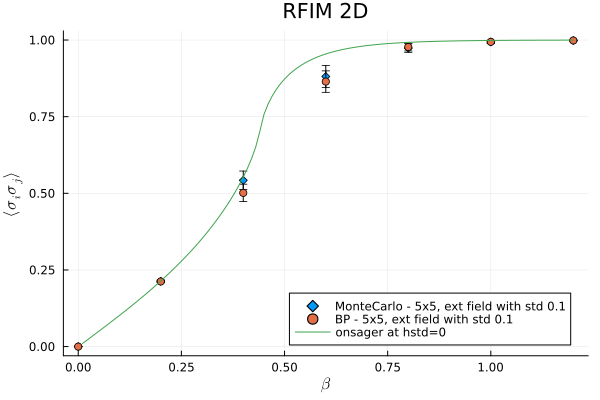

In [43]:
pl = plot(xlabel=L"\beta", ylabel=L"\langle \sigma_i \sigma_j \rangle", title="RFIM 2D")
# for i in eachindex(betas)
#     scatter!(pl, fill(betas[i], ninstances), mean.(c_mc[i]), m=:diamond, c=:black,
#         label=(i == 1 ? "MonteCarlo - N=$N, h0=$h0" : ""))
# end
# for i in eachindex(betas)
#     scatter!(pl, fill(betas[i], ninstances), mean.(c_bp[i]), c=:red, m=:star,
#         label=(i == 1 ? "BP - N=$N, h0=$h0" : ""))
# end
scatter!(pl, betas, mean.(mean.(c_mc)), yerr = std.(mean.(c_mc)), m=:diamond, 
    label="MonteCarlo - $(N)x$N, ext field with std $hstd")
scatter!(pl, betas, mean.(mean.(c_bp)), yerr = std.(mean.(c_bp)), label="BP - $(N)x$N, ext field with std $hstd")
plot!(pl, β -> -onsager_energy(J, β)/2,  betas[1]:0.01:betas[end], label="onsager at hstd=0")
plot(pl, legend=:bottomright)

In [161]:
# using JLD2
# jldsave("rfim_infinite_N$N.jld2"; N, betas, ninstances, h0, c_mc, c_bp)

In [173]:
# pl = plot(xlabel="β", ylabel="avg correlation", title="RFIM 2D")

# ns = [5, 10, 25]
# cg = cgrad(:matter, length(ns), categorical=true)
# for (j,n) in pairs(ns) 
#     @unpack N, betas, ninstances, h0, c_mc, c_bp = load("rfim_infinite_N$n.jld2")
#     scatter!(pl, mean.(mean.(c_mc)), c=cg[j], m=:diamond, label="MonteCarlo - N=$N, h0=$h0")
#     plot!(pl, mean.(mean.(c_bp)), c=cg[j], label="BP - N=$N, h0=$h0")
# end
# plot(pl, legend=:bottomright)

## Increasing N

In [43]:
Ns = [3, 6, 10, 15, 25, 40]
ninstances = 20
J = 1.0
hstd = 0.1
ntherm = 10^4
nsamples = 10^6
betas = 0:0.1:1.2;

In [ ]:
stats = map(Ns) do N
    map(betas) do β
        println("Temperature β=$β")
        rfim2d_montecarlo(N, β, J, hstd, ninstances; ntherm, nsamples, hbias)
    end
end;

Temperature β=0.0


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 

Temperature β=0.1


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 

Temperature β=0.2


Progress:  50%|████████████████████▋                    |  ETA: 0:00:01

In [ ]:
mabs_mc, c_mc, m_mc = map(zip(Ns, stats)) do (N, s)
    observables_mc.(N, s) |> unzip
end |> unzip;

In [ ]:
svd_trunc = TruncBondThresh(8, 1e-8)
maxiter = 100
m_bp, c_bp = map(Ns) do N
    map(betas) do β
        println("Temperature β=$β")
        rfim2d_bp(N, β, J, hstd, ninstances; svd_trunc, maxiter, hbias)
    end |> unzip
end |> unzip;

In [ ]:
jldsave("rfim_infinite.jld2"; Ns, betas, c_mc, c_bp);

In [ ]:
cg = cgrad(:matter, length(Ns)+1, categorical=true)
pl = plot(title="External field std=$hstd")
for (k,N) in pairs(Ns)
    plot!(pl, betas, mean.(mean.(c_mc[k])), yerr = std.(mean.(c_mc[k])), m=:diamond, c=cg[k+1],
        label="MonteCarlo - $(N)x$N")
    plot!(pl, betas, mean.(mean.(c_bp[k])), yerr = std.(mean.(c_bp[k])), m=:circle, c=cg[k+1],
        label="MPBP - $(N)x$N", ls=:dash)
end
pl